<a href="https://colab.research.google.com/github/Irsnag/cassiopee-74/blob/main/segmentation_d'images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation d'images avec model sans poids ajustés

In [ ]:
# Importation des bibliothèques nécessaires
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt

import numpy as np

In [ ]:

def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result



## Chargement & préprocessing des données


In [ ]:
# Chargement des fichiers de matrices de luminances et des labels (masks)
image_data = np.load("/home/taha/Desktop/Cassiopee/Donnees/new_data.npy").astype(np.float32)
label_data = np.load("/home/taha/Desktop/Cassiopee/Donnees/new_mask.npy")

image_data = np.expand_dims(image_data, axis=-1)
label_data = np.expand_dims(label_data, axis=-1)
# Création d'un dataset
dataset = tf.data.Dataset.from_tensor_slices((image_data, label_data))


In [ ]:
#affichage des dimensions de la data
print(np.shape(image_data))

(14, 1280, 704, 1)


 Les pixels dans les masks de segmentation appartiennent  à {0,1}

In [ ]:
# Définition des constantes pour l'entraînement du modèle
TRAIN_LENGTH = sum(1 for _ in dataset)
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

2023-06-14 16:28:12.237345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [14,1280,704,1]
	 [[{{node Placeholder/_1}}]]


In [ ]:
# Diviser le dataset en ensembles de données d'entraînement et de test
num_examples = sum(1 for _ in dataset)
test_percent = 0.2
num_test_examples = int(num_examples * test_percent)
test_images = dataset.take(num_test_examples)
train_images = dataset.skip(num_test_examples)

La classe suivante effectue une simple augmentation de données en pivotant les données. Comme les données sont des matrices de luminance associées à des images, les pivoter horizontalement donnera des images sans trop de sens, du coup on ne s'intéresse qu'à l'augmentation verticale

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # Les deux utilisent la même graine (seed), elles effectueront donc les mêmes modifications aléatoires.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="vertical", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="vertical", seed=seed)

  def call(self, inputs, labels):
    # Appliquer l'augmentation aux entrées et aux étiquettes
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
# Contruction du pipeline d'entrée pour l'entraînement du modèle
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE) # Mélange aléatoire des données pour une meilleure généralisation
    .batch(BATCH_SIZE)  # Mise en lots des données avec une taille de lot fixe
    .repeat()  # Répétition des mini-lots pour permettre l'entraînement sur plusieurs époques
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)) # Préchargement des données pour une exécution plus fluide

# Mise en lots des données de test
test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
print((test_batches))
print((train_batches))

<_BatchDataset element_spec=(TensorSpec(shape=(None, 1280, 704, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1280, 704, 1), dtype=tf.float64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 1280, 704, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1280, 704, 1), dtype=tf.float32, name=None))>


##Visualisation de la matrice de luminance et son mask correspondant du dataset:

In [ ]:


def display(display_list):
#  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


2023-06-14 16:35:51.699966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype resource
	 [[{{node Placeholder/_19}}]]
2023-06-14 16:35:51.700911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [14,1280,704,1]
	 [[{{node Placeholder/_1}}]]


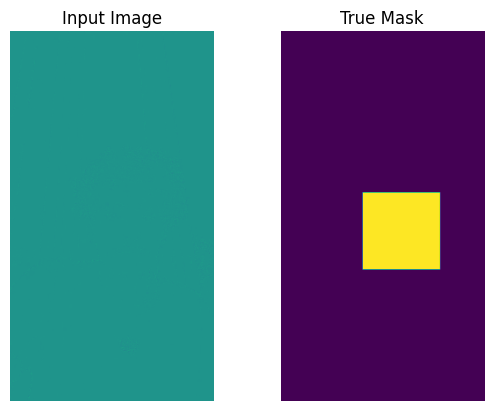

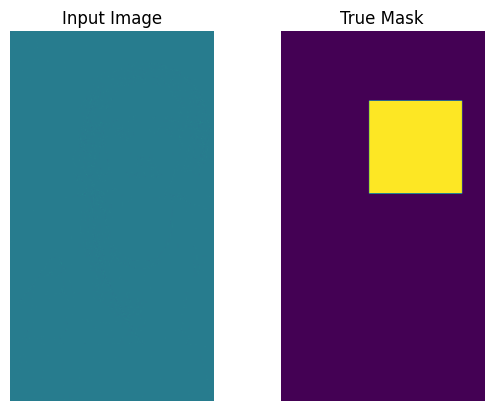

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

C'est normal que la matrice de luminance ne ressemble à rien car les pixel représente les luminance de l'image original

## Définition du model
Nous adaptons le modèle utilisé dans (https://www.tensorflow.org/tutorials/images/segmentation?hl=fr&fbclid=IwAR0iD-4yDMmWrC8aeFmw1UJE1RTRMLPWBXNcU7lQgjHKOV4O-rZzQhiSnjw)

Le modèle utilisé ici est un U-Net modifié. Un U-Net se compose d'un encodeur (downsampler) et d'un décodeur (upsampler). Afin de réduire le nombre de paramètres pouvant être entrainés, un modèle pré-entrainé - MobileNetV2 - est utilisé comme encodeur. Pour le décodeur, on utilise le bloc upsample, qu'on a développé en tout début du code.

L'encodeur se compose de sorties spécifiques des couches intermédiaires du modèle. Notez que l'encodeur ne sera pas formé pendant le processus de formation.

In [ ]:

# Définition de la forme de l'entrée du modèle
input_tensor = tf.keras.layers.Input(shape=(1280, 704, 1))

# Duplication des canaux pour obtenir une entrée avec 3 canaux identiques pour qu'il s'adapte à l'entrée du modèle pré-entrainé
input_tensor_3ch = tf.keras.layers.Concatenate()([input_tensor, input_tensor, input_tensor])

# Chargement du modèle pré-entraîné MobileNetV2 avec les entrées en 3 canaux
base_model = tf.keras.applications.MobileNetV2(input_tensor=input_tensor_3ch, include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 640x352
    'block_3_expand_relu',   # 320x176
    'block_6_expand_relu',   # 160x88
    'block_13_expand_relu',  # 80x44
    'block_16_project',      # 40x22
]

# Récupération des sorties des couches spécifiées du modèle pré-entraîné
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Création du modèle d'extraction des features
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# Désactivation de l'entraînement des couches du modèle pré-entraîné
down_stack.trainable = False


In [ ]:
up_stack = [
    upsample(512, 3),  # 40x22 -> 80x44
    upsample(256, 3),  # 80x44 -> 160x88
    upsample(128, 3),  # 160x88 -> 320x176
    upsample(64, 3),   # 320x176 -> 640x352
]

## Entraînement du model

Nous utilisons la fonction de perte tf.keras.losses.SparseCategoricalCrossentropy qui est appropriée pour les problèmes de classification avec plusieurs classes lorsque les étiquettes de classe sont fournies en tant qu'entiers

In [ ]:
OUTPUT_CLASSES = 2
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=(1280, 704, 1))

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same', activation='softmax')

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

# Création du modèle U-Net avec le nombre de canaux de sortie égal à OUTPUT_CLASSES
model = unet_model( output_channels=OUTPUT_CLASSES)

# Configuration des paramètres d'entraînement du modèle
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Notez que le nombre de filtres sur la dernière couche est défini sur le nombre de output_channels . Ce sera un canal de sortie par classe.

L'architecture du modèle résultant :



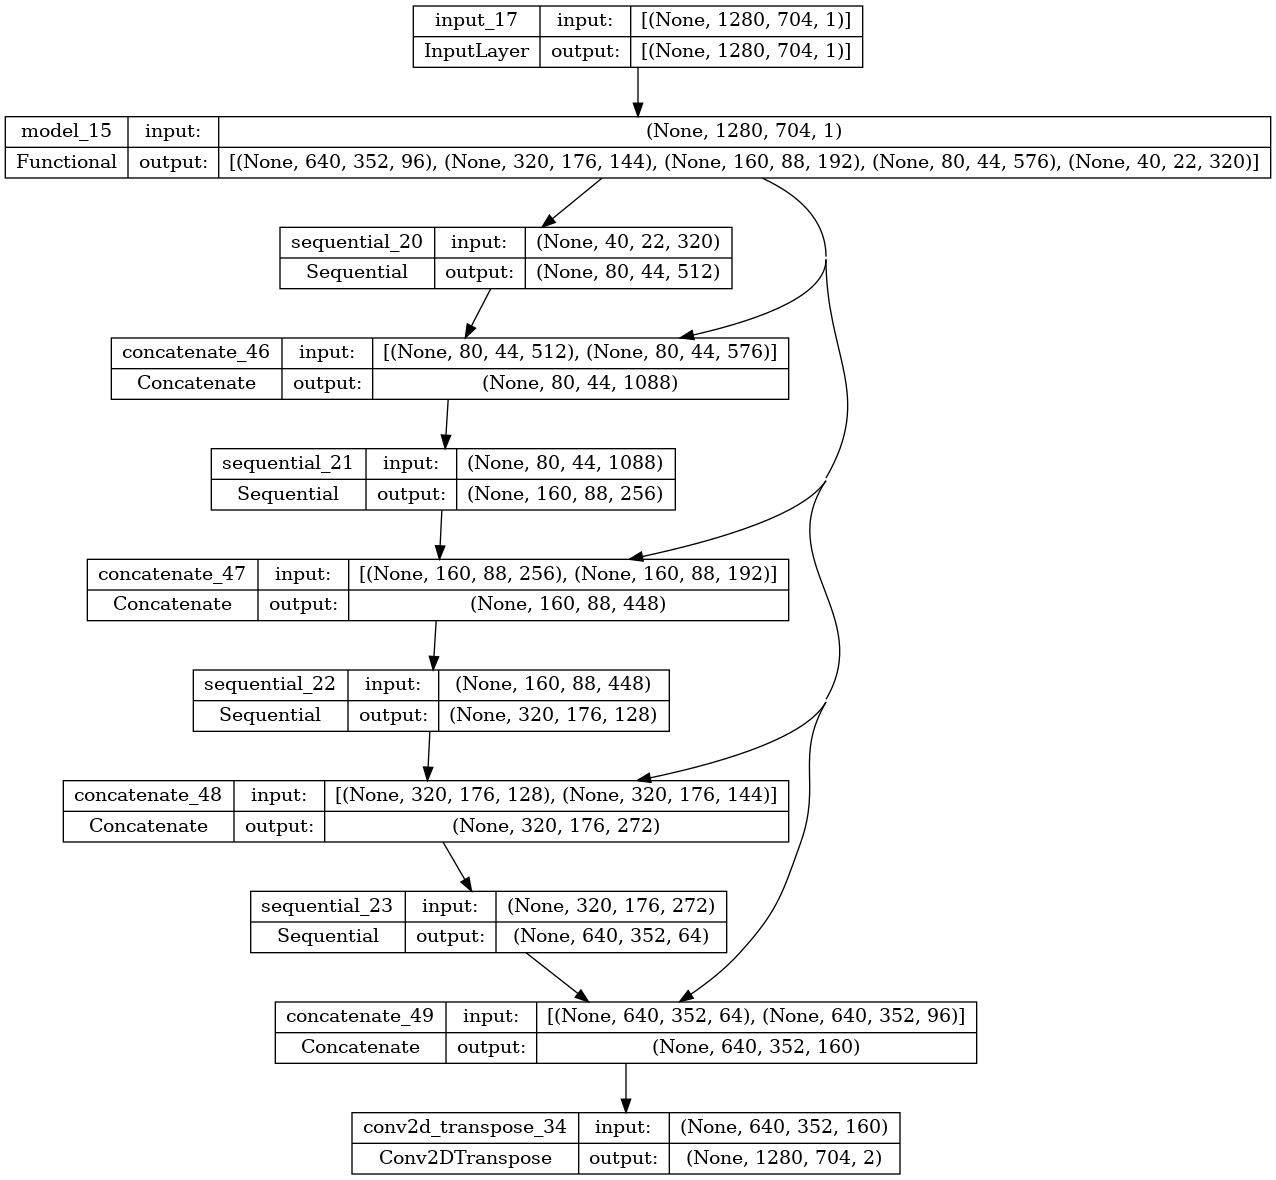

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

 La fonction create_mask retourne le mask prédit, en prenant l'étiquette avec la probabilité la plus élevée pour chaque pixel.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

La fonction show_predictions permet d'afficher l'image (matrice de luminance), le true mask qui est le vrai mask et le predicted mask qui est le mask prédit

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

Le callback défini ci-dessous est utilisé pour observer comment le modèle s'améliore pendant son entraînement.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 1s 1s/step


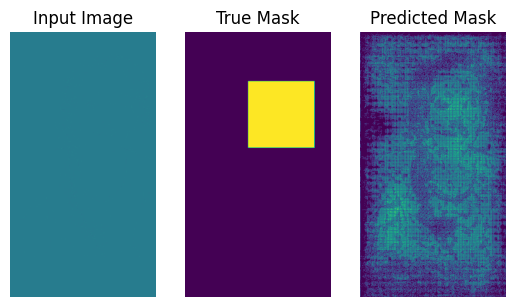


Sample Prediction after epoch 3

7/7 [==============================] - 31s 4s/step - loss: 0.3727 - accuracy: 0.8919


In [ ]:
EPOCHS = 3
VAL_SUBSPLITS = 5
VALIDATION_STEPS =  len(test_batches) // VAL_SUBSPLITS



model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

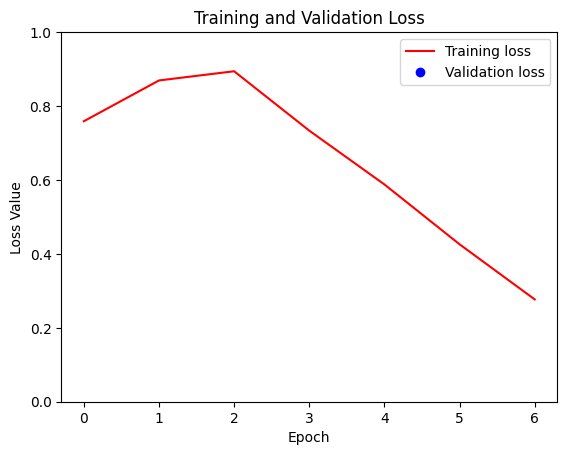

In [ ]:
loss = model_history.history['loss']
#val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
#plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Faisons maintenant des prédictions

2023-06-14 16:38:03.071795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [14,1280,704,1]
	 [[{{node Placeholder/_1}}]]
2023-06-14 16:38:03.072313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [14,1280,704,1]
	 [[{{node Placeholder/_1}}]]


1/1 [==============================] - 2s 2s/step


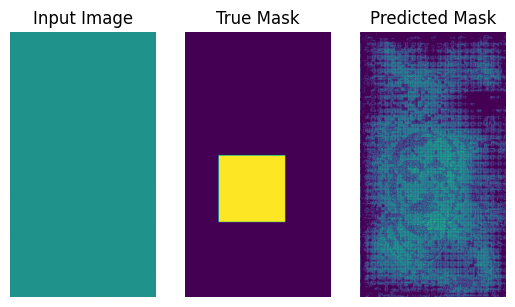

In [ ]:
show_predictions(test_batches, 3)

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import matplotlib.colors as mcolors

In [ ]:
#adaptons la palette de couleur
couleur_zero = (60, 0, 80)  # Violet foncé
couleur_un = (255, 255, 0)  # Jaune vif

# Convertir les valeurs RGB en plage de 0 à 1
couleur_zero_norm = tuple(c / 255 for c in couleur_zero)
couleur_un_norm = tuple(c / 255 for c in couleur_un)

# Créer une palette de couleurs personnalisée
colors = [couleur_zero_norm, couleur_un_norm]
cmap = mcolors.ListedColormap(colors)

1/1 [==============================] - 2s 2s/step


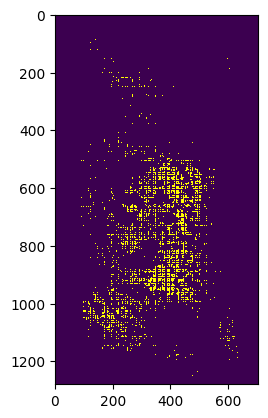

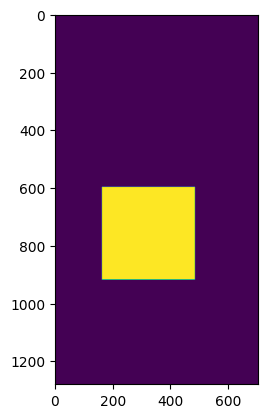

In [ ]:
for image, mask in test_batches:
      pred_mask = model.predict(image)
      plt.imshow(create_mask(pred_mask), cmap = cmap)
      plt.show()
      plt.imshow(mask[0])
      plt.show()

1/1 [==============================] - 2s 2s/step


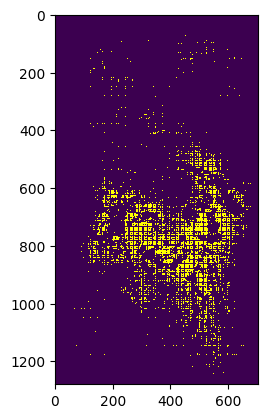

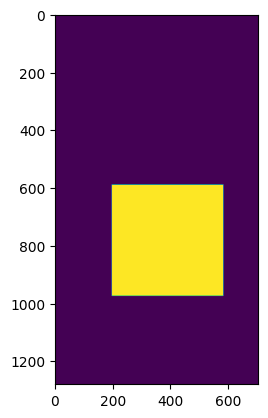

1/1 [==============================] - 3s 3s/step


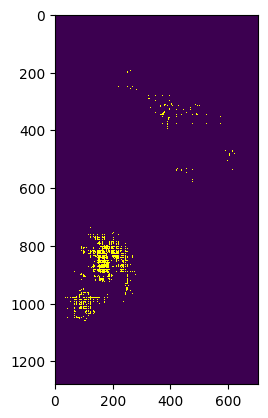

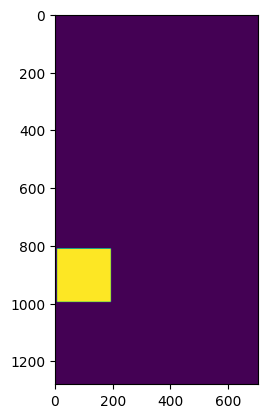

1/1 [==============================] - 3s 3s/step


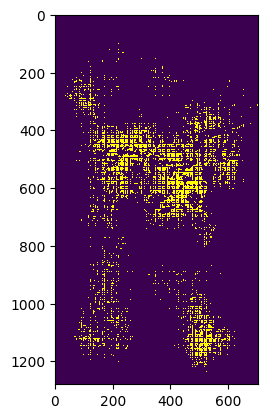

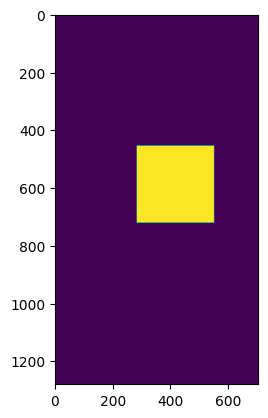

1/1 [==============================] - 3s 3s/step


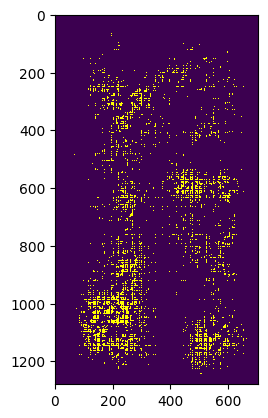

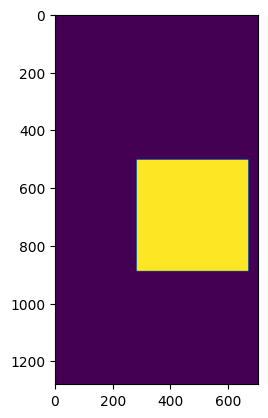

1/1 [==============================] - 3s 3s/step


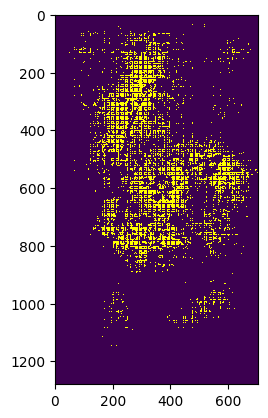

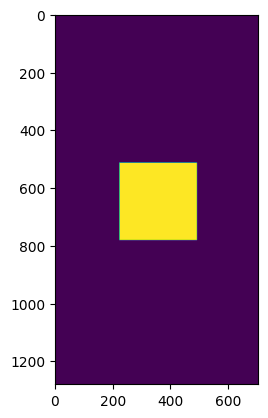

1/1 [==============================] - 3s 3s/step


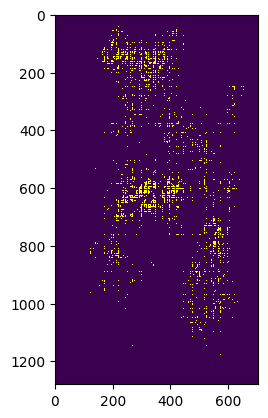

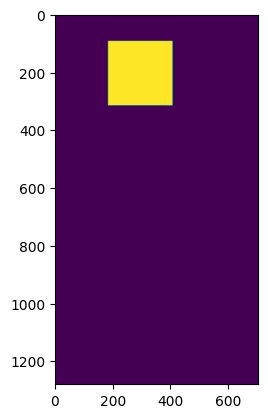

1/1 [==============================] - 3s 3s/step


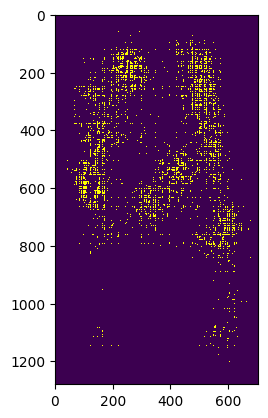

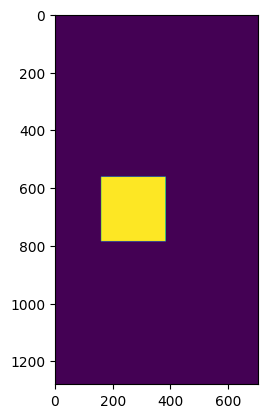

1/1 [==============================] - 3s 3s/step


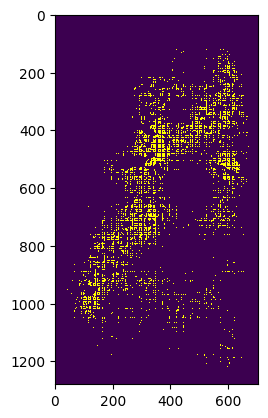

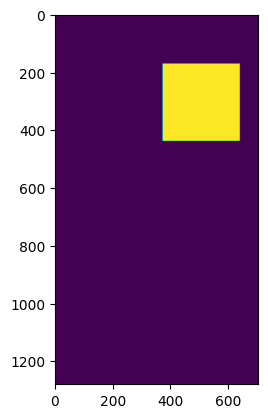

1/1 [==============================] - 2s 2s/step


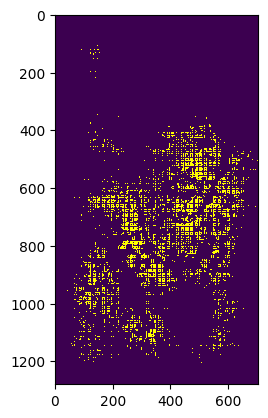

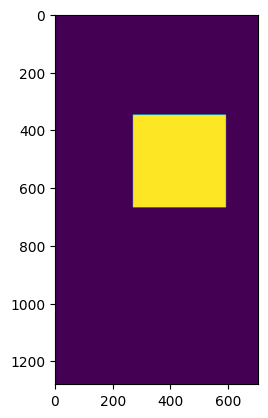

1/1 [==============================] - 2s 2s/step


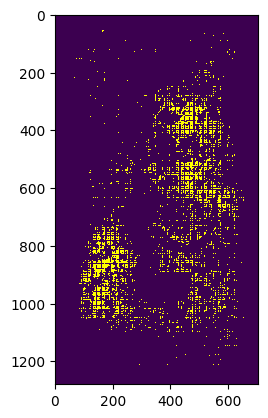

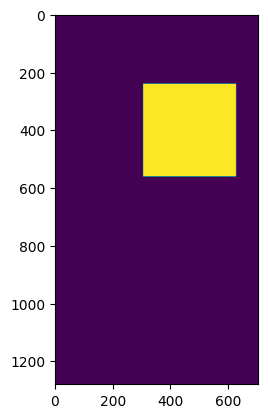

1/1 [==============================] - 2s 2s/step


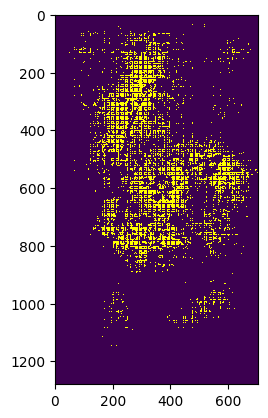

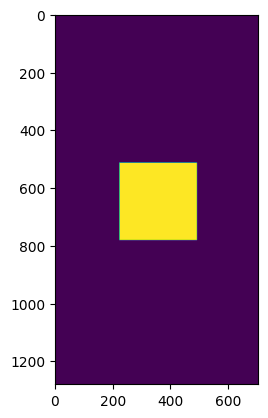

1/1 [==============================] - 2s 2s/step


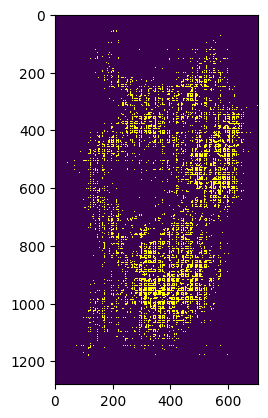

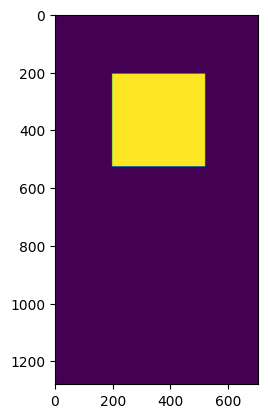

1/1 [==============================] - 3s 3s/step


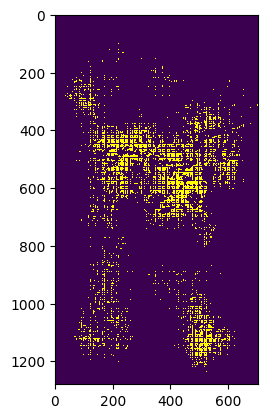

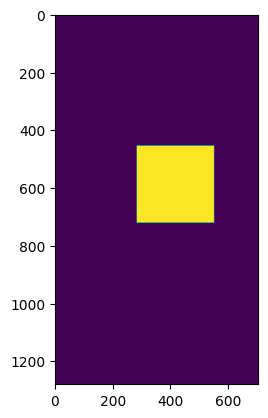

1/1 [==============================] - 3s 3s/step


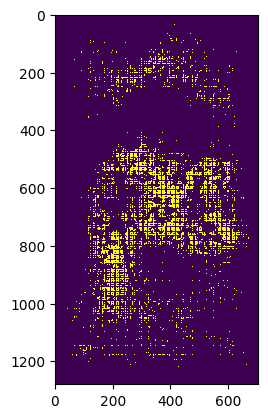

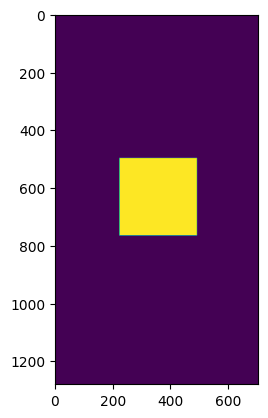

KeyboardInterrupt: 

In [ ]:
#attention ce code est infini vu que train_batches est infini
from matplotlib.colors import ListedColormap

for image, mask in train_batches:
      pred_mask = model.predict(image)
      plt.imshow(create_mask(pred_mask), cmap = cmap)
      plt.show()
      plt.imshow(mask[0])
      plt.show()


## Segmentation d'images avec model sans poids ajustés


Les pixels de classe 0 représentent la majorité des pixels du mask alors qu'ils ne sont pas les plus importants. Étant donné que les problèmes de segmentation peuvent être traités comme des problèmes de classification par pixel, nous pouvons traiter le problème de déséquilibre en pondérant la fonction de perte pour en tenir compte.

Nous utilisons à la place du couple  (data, label) pour Model.fit, le triplet (data, label, sample_weight) .

Model.fit propage le sample_weight aux pertes et aux métriques, qui acceptent également un argument sample_weight . Le poids de l'échantillon est multiplié par la valeur de l'échantillon avant l'étape de réduction.

In [ ]:
def add_sample_weights(image, label):
  # Les poids pour chaque classe

  class_weights = tf.constant([1.0, 1.1])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Création d'un vecteur `sample_weights` rempli des poids correspondants aux label 1 ou 0 à chaque pixel : indices de class weights .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

Les éléments du dataset résultant contiennent 3 éléments chacun, l'image et le label du dataset d'origine et en plus "sample_weights" un vecteur du même format que le label, où chaque pixel contient le poids de classe correspondant à ce pixel.

In [ ]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 1280, 704, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1280, 704, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1280, 704, 1), dtype=tf.float32, name=None))

In [ ]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

1/1 [==============================] - 1s 1s/step


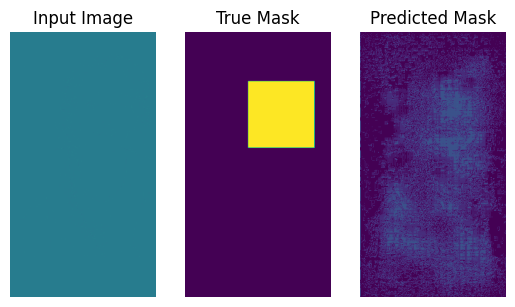


Sample Prediction after epoch 3

7/7 [==============================] - 32s 5s/step - loss: 0.1593 - accuracy: 0.8933


In [ ]:
weighted_model_history = weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    callbacks=[DisplayCallback()])

In [ ]:
loss = weighted_model_history.history['loss']
val_loss = weighted_model_history.history['val_loss']

plt.figure()
plt.plot(weighted_model_history.epoch, loss, 'r', label='Training loss')
plt.plot(weighted_model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

KeyError: 'val_loss'

In [ ]:
def show_predictions2(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = weighted_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(weighted_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 5s 5s/step


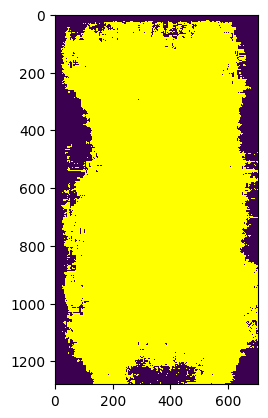

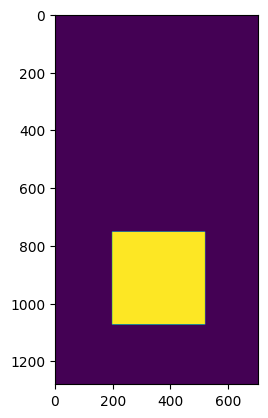

1/1 [==============================] - 3s 3s/step


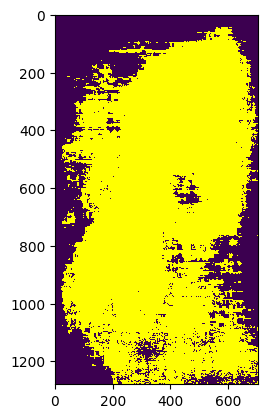

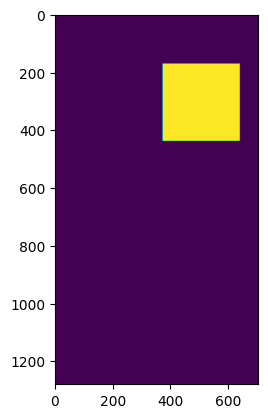

1/1 [==============================] - 2s 2s/step


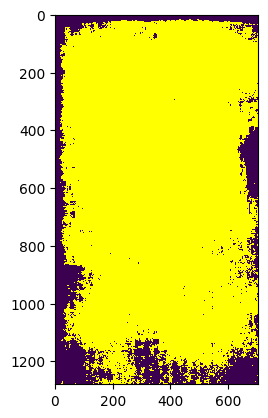

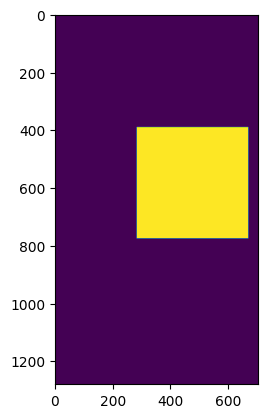

1/1 [==============================] - 3s 3s/step


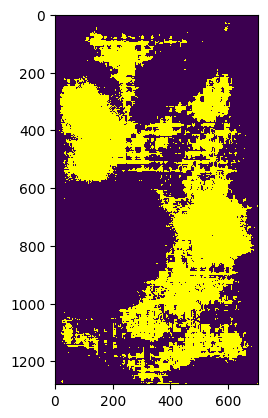

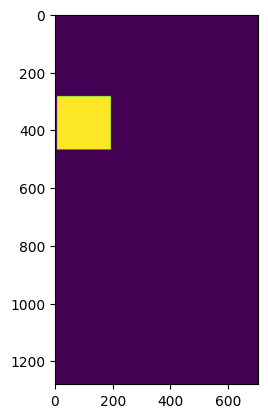

1/1 [==============================] - 3s 3s/step


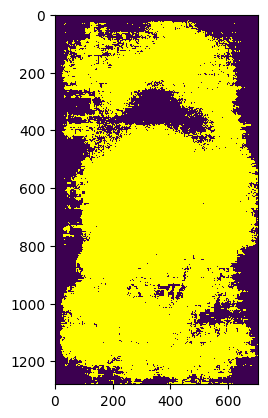

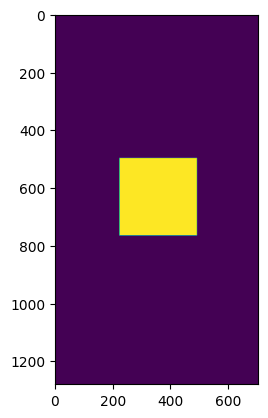

1/1 [==============================] - 2s 2s/step


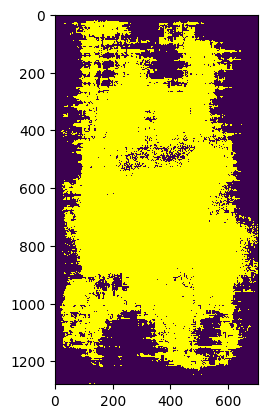

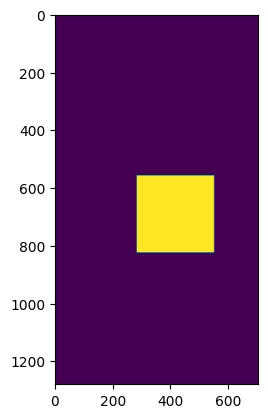

1/1 [==============================] - 2s 2s/step


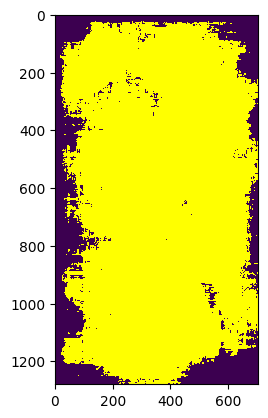

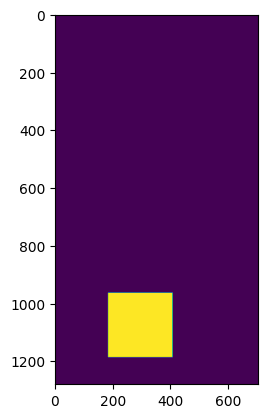

1/1 [==============================] - 2s 2s/step


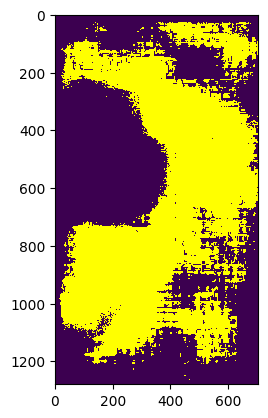

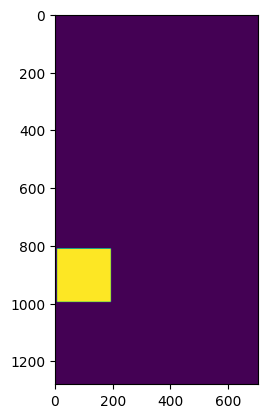

1/1 [==============================] - 2s 2s/step


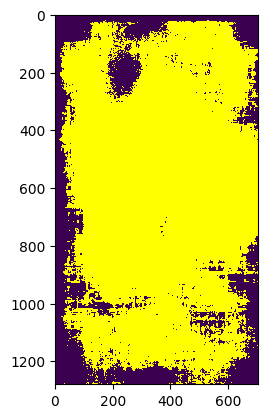

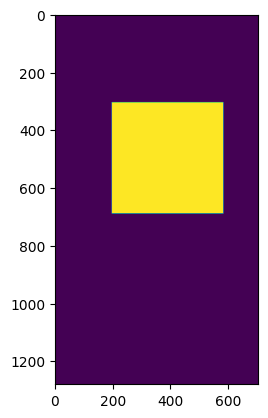

1/1 [==============================] - 2s 2s/step


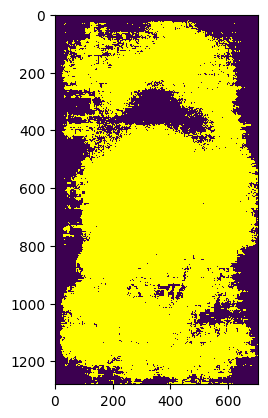

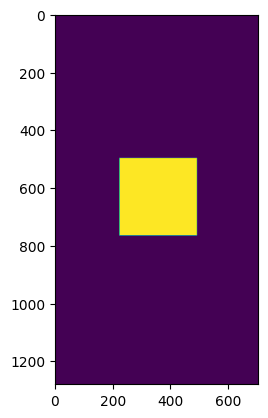

1/1 [==============================] - 2s 2s/step


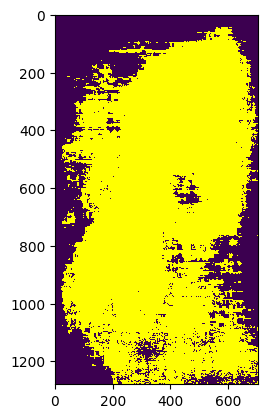

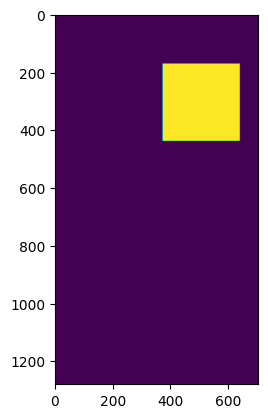

KeyboardInterrupt: 

In [ ]:
for image, mask in train_batches:
      pred_mask = weighted_model.predict(image)
      #display([image[0], mask[0], create_mask(pred_mask)])
      plt.imshow(create_mask(pred_mask), cmap = cmap)
      plt.show()
      plt.imshow(mask[0])
      plt.show()


1/1 [==============================] - 3s 3s/step


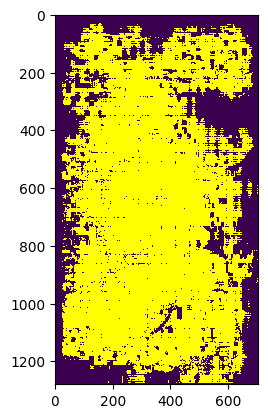

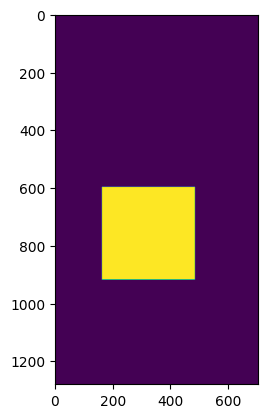

In [ ]:
for image, mask in test_batches:
      pred_mask = weighted_model.predict(image)
      #display([image[0], mask[0], create_mask(pred_mask)])
      plt.imshow(create_mask(pred_mask), cmap = cmap)
      plt.show()
      plt.imshow(mask[0])
      plt.show()